In [12]:
import json
import matplotlib.pyplot as plt
import torch

from dataset import words_dataset
from transformer_model import TransformerModel, load_model
from train import  TrainingConfig, eval_model

In [ ]:
penalty_model = load_model(
    '/nas04/krchicke/projects/impermissible_tokens/penalty_experiment/penalty',
    device='cpu'
)
no_penalty_model = load_model(
    '/nas04/krchicke/projects/impermissible_tokens/penalty_experiment/no_penalty',
    device='cpu'
)

In [22]:
vocab_size = getattr(no_penalty_model, "vocab_size", None)
dataset_args = {
    'n_impermissible_tokens': 4,
    'impermissible_token_idxs': [0, 1, 2, 3]
}
if not vocab_size:
    dataset = words_dataset(**dataset_args)
else:
    dataset = words_dataset(vocab_size=vocab_size, **dataset_args)

In [23]:
def view_attn(no_penalty_model, penalty_model, dataset, n_samples=10):
    sample = dataset[n_samples]
    imp_token_idx = sample[0].argmin(dim=-1)

    np_out, np_attn = no_penalty_model(sample[0], return_attn=True)
    p_out, p_attn = penalty_model(sample[0], return_attn=True)

    np_attn_score = np_attn.sum(dim=1)
    p_attn_score = p_attn.sum(dim=1)

    np_predicted = np_out.argmax(dim=1)
    p_predicted = p_out.argmax(dim=1)

    fig, axs = plt.subplots(n_samples, 2, figsize=(8, 4 * n_samples))

    for i in range(n_samples):
        ax1 = axs[i, 0]
        ax2 = axs[i, 1]

        other_idxs = [j for j in range(len(np_attn_score[i, :])) if j != imp_token_idx[i]]

        ax1.bar(other_idxs, np_attn_score[i, other_idxs].detach(), color='blue')
        ax1.bar(imp_token_idx[i], np_attn_score[i, imp_token_idx].detach(), color='red')

        ax2.bar(other_idxs, p_attn_score[i, other_idxs].detach(), color='blue')
        ax2.bar(imp_token_idx[i], p_attn_score[i, imp_token_idx].detach(), color='red')

        ax1.set_ylabel('Attention Score')
        ax1.set_xlabel('Token Index')
        ax1.set_title(f"No Penalty Model: predicted {np_predicted[i].item()}, actual {sample[1][i].item()}")
        ax2.set_xlabel('Token Index')
        ax2.set_title(f"Penalty Model: predicted {p_predicted[i].item()}, actual {sample[1][i].item()}")

    plt.tight_layout()
    plt.show()

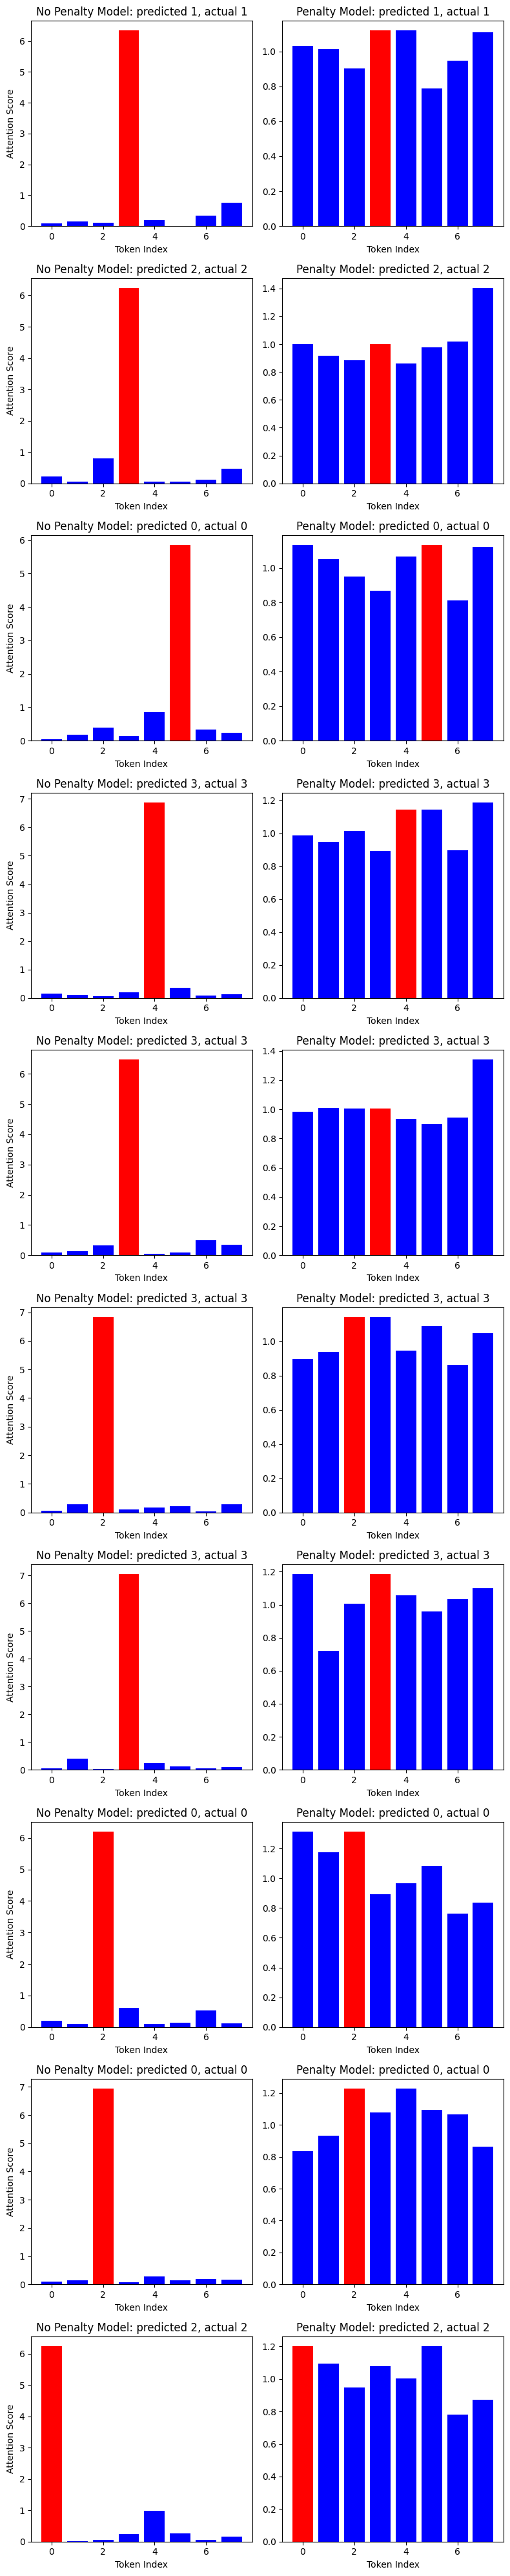

In [24]:
view_attn(no_penalty_model, penalty_model, dataset)